# Voxel-based Sampling Walkthrough

This notebook demonstrates how to:
- Load a membrane mask `.mrc`
- Extract surface voxels and per-voxel orientations via `info_extract`
- Perform voxel-level sampling with a minimum-distance constraint via `sample`
- Visualize sampling results in 3D


In [1]:
# Imports and configuration
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# TomoPANDA imports
from tomopanda.utils.mrc_utils import MRCReader
from tomopanda.core.voxel_sample import info_extract, sample

# Set a default path to an example mask in results (change as needed)
DEFAULT_MASK_PATH = '/home/muwang/Documents/projects/IR/20230518IR_mCherry/memseg_output_frames1_2_10A/rec_pinkss_MGS002_T2_ts_002_px10_MemBrain_seg_v10_beta.ckpt_segmented.mrc'
print('Default mask path:', DEFAULT_MASK_PATH)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Default mask path: /home/muwang/Documents/projects/IR/20230518IR_mCherry/memseg_output_frames1_2_10A/rec_pinkss_MGS002_T2_ts_002_px10_MemBrain_seg_v10_beta.ckpt_segmented.mrc


In [2]:
# Load membrane mask MRC
mask_path = DEFAULT_MASK_PATH

# If you want to override:
# mask_path = Path('/absolute/path/to/your/mask.mrc')

mask, meta = MRCReader.read_mrc(mask_path)
print('Loaded mask shape (Z,Y,X)? meta says:', meta.get('shape'))

# Convert to (X,Y,Z) and 0/1 as required by info_extract spec
# Our reader typically returns (Z,Y,X). We transpose to (X,Y,Z)
mask = (mask > 0).astype(np.uint8)
mask_xyz = np.transpose(mask, (2,1,0))
print('mask_xyz shape (X,Y,Z):', mask_xyz.shape)

# Quick sanity visual (optional):
# plt.imshow(mask_xyz[:, :, mask_xyz.shape[2]//2]); plt.show()


Loaded mask shape (Z,Y,X)? meta says: (335, 671, 671)
mask_xyz shape (X,Y,Z): (671, 671, 335)


In [3]:
# Extract surface info
surface_mask, orientations = info_extract(mask_xyz)
print('surface_mask shape:', surface_mask.shape)
print('orientations shape:', orientations.shape)
print('num surface voxels:', int(surface_mask.sum()))


surface_mask shape: (671, 671, 335)
orientations shape: (3, 671, 671, 335)
num surface voxels: 610403


In [4]:
# Run voxel sampling
min_distance = 20.0  # in voxels/pixels
particle_size = 40.0 # in voxels/pixels (kept for API completeness)

field = sample(min_distance, particle_size, surface_mask, orientations)
print('field shape (6,X,Y,Z):', field.shape)

# Extract selected points
xs, ys, zs = np.nonzero(field[0] > 0)
coords = np.stack([field[0, xs, ys, zs], field[1, xs, ys, zs], field[2, xs, ys, zs]], axis=1)
normals = np.stack([field[3, xs, ys, zs], field[4, xs, ys, zs], field[5, xs, ys, zs]], axis=1)
print('selected points:', len(coords))


field shape (6,X,Y,Z): (6, 671, 671, 335)
selected points: 586


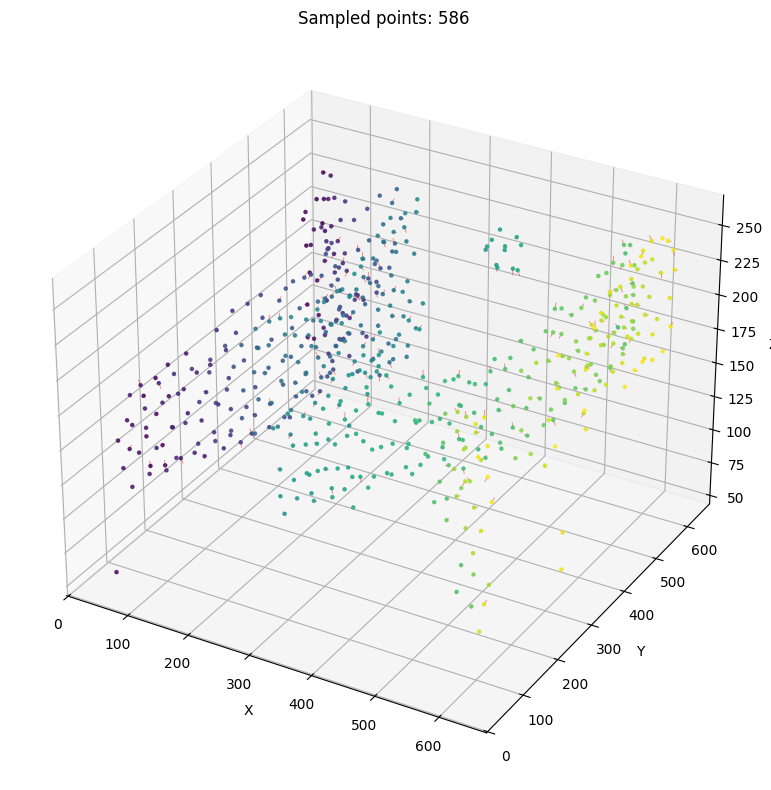

In [5]:
# 3D visualization (matplotlib)
from mpl_toolkits.mplot3d.art3d import Line3DCollection

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Downsample for display if too many points
max_points = 2000
if len(coords) > max_points:
    idx = np.random.choice(len(coords), max_points, replace=False)
    coords_vis = coords[idx]
    normals_vis = normals[idx]
else:
    coords_vis = coords
    normals_vis = normals

ax.scatter(coords_vis[:,0], coords_vis[:,1], coords_vis[:,2], s=5, c=np.linspace(0,1,len(coords_vis)), cmap='viridis', alpha=0.8)

# Draw a subset of normals as line segments
step = max(1, len(coords_vis)//200)
segments = []
for i in range(0, len(coords_vis), step):
    p = coords_vis[i]
    v = normals_vis[i] * 5.0
    segments.append([p, p + v])

if segments:
    lc = Line3DCollection(segments, colors='red', linewidths=0.5, alpha=0.6)
    ax.add_collection(lc)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Sampled points: {len(coords)}')
plt.tight_layout()
plt.show()


In [ ]:
# Interactive 3D visualization (Plotly): function + call
import numpy as np
import plotly.graph_objects as go

def plot_particles_interactive(coords: np.ndarray,
                               normals: np.ndarray,
                               *,
                               max_points_plot: int = 5000,
                               num_arrows: int = 800,
                               arrow_scale_frac: float = 0.05,
                               cone_radius_frac: float = 0.01,
                               marker_size: float = 2.0,
                               show_shafts: bool = True,
                               shaft_width: float = 2.0,
                               shaft_color: str = 'red') -> None:
    if coords is None or normals is None:
        raise ValueError('coords/normals cannot be None')
    if len(coords) == 0:
        raise ValueError('coords is empty')

    # Downsample for display
    if len(coords) > max_points_plot:
        idx_pts = np.random.choice(len(coords), max_points_plot, replace=False)
        coords_vis = coords[idx_pts]
        normals_vis = normals[idx_pts]
    else:
        coords_vis = coords
        normals_vis = normals

    # Robust scene scale from data extent
    data_extent = np.ptp(coords_vis, axis=0)  # range along each axis
    max_range = float(np.max(data_extent)) if np.all(np.isfinite(data_extent)) and np.max(data_extent) > 0 else 1.0
    arrow_len = float(arrow_scale_frac) * max_range
    cone_radius = max(float(cone_radius_frac) * max_range, 1e-6)

    # Normalize normals and guard against zeros
    norms = np.linalg.norm(normals_vis, axis=1)
    safe_norms = np.where(norms > 0, norms, 1.0)
    normals_unit = normals_vis / safe_norms[:, None]

    # Points
    points_trace = go.Scatter3d(
        x=coords_vis[:, 0], y=coords_vis[:, 1], z=coords_vis[:, 2],
        mode='markers',
        marker=dict(size=marker_size, color=coords_vis[:, 2], colorscale='Viridis', opacity=0.9),
        name='particles'
    )

    data = [points_trace]

    # Arrows as cones from subset
    n_arrows = int(min(num_arrows, len(coords_vis)))
    if n_arrows > 0 and arrow_len > 0:
        arrow_idx = np.linspace(0, len(coords_vis) - 1, num=n_arrows, dtype=int)
        arrow_bases = coords_vis[arrow_idx]
        arrow_dirs = normals_unit[arrow_idx]

        u = arrow_dirs[:, 0] * arrow_len
        v = arrow_dirs[:, 1] * arrow_len
        w = arrow_dirs[:, 2] * arrow_len

        cones_trace = go.Cone(
            x=arrow_bases[:, 0], y=arrow_bases[:, 1], z=arrow_bases[:, 2],
            u=u, v=v, w=w,
            anchor='tail',
            colorscale='Reds', showscale=False,
            sizemode='absolute', sizeref=cone_radius,
            name='orientation',
            lighting=dict(ambient=0.6, diffuse=0.8, specular=0.2)
        )
        data.append(cones_trace)

        # Optional line shafts for visibility independent of cone rendering
        if show_shafts:
            xs = np.empty(3 * n_arrows)
            ys = np.empty(3 * n_arrows)
            zs = np.empty(3 * n_arrows)
            xs[0::3] = arrow_bases[:, 0]
            ys[0::3] = arrow_bases[:, 1]
            zs[0::3] = arrow_bases[:, 2]
            xs[1::3] = arrow_bases[:, 0] + u
            ys[1::3] = arrow_bases[:, 1] + v
            zs[1::3] = arrow_bases[:, 2] + w
            xs[2::3] = np.nan
            ys[2::3] = np.nan
            zs[2::3] = np.nan

            shafts_trace = go.Scatter3d(
                x=xs, y=ys, z=zs,
                mode='lines',
                line=dict(width=shaft_width, color=shaft_color),
                name='orientation_shaft',
                opacity=0.7
            )
            data.append(shafts_trace)

    fig = go.Figure(data=data)
    fig.update_layout(
        title=f'Interactive particles: total={len(coords)} shown={len(coords_vis)}',
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='data'),
        margin=dict(l=0, r=0, t=40, b=0)
    )
    fig.show()

# Call with existing variables from previous cells
if 'coords' not in globals() or 'normals' not in globals():
    raise RuntimeError('coords/normals not found. Run the sampling cells first.')
plot_particles_interactive(coords, normals)

